In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Import Preprocessed Data

In [2]:
data = pickle.load( open( "data_v1.pkl", "rb" ) )
X_train, y_train, X_val, y_val, X_test, y_test = data

### Define Model

In [3]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        Query = self.pre_norm_Q(Query)
        Key = self.pre_norm_K(Key)
        Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 256
        self.num_heads = 4
        self.num_jet_feats = 4
        self.num_trk_feats = 6
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.jet_trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
            
        # Track Encoder Stack
        self.trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        self.jet_postprocess = nn.Linear(self.embed_dim*2, self.embed_dim)
        
        # All Track Encoder Stack
        self.all_trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Cross Encoder Stack
        self.cross_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Jet Encoder Stack
        self.jet_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder3 = Encoder(self.embed_dim, self.num_heads)

        # Regression Task
        self.regression = nn.Linear(self.embed_dim, 1)
        
    def forward(self, jets, jet_trks, trks):
        # Feature preprocessing layers
        jet_init = F.relu(self.jet_initializer(jets))
        jet_trk_init = F.relu(self.jet_trk_initializer(jet_trks))
        trk_init = F.relu(self.trk_initializer(trks))
        
        # Calculate aggregated tracks using attention
        jet_trk_embedding, trk_weights = self.trk_encoder1(jet_trk_init, jet_trk_init, jet_trk_init)
        jet_trk_embedding, trk_weights = self.trk_encoder2(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        jet_trk_embedding, trk_weights = self.trk_encoder3(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        
        # Generate meaningful jet_embedding using info from trk_aggregated  
        jet_trk_aggregated = jet_trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, jet_trk_aggregated),1)
        jet_embedding = F.relu(self.jet_postprocess(jet_embedding))
        
        # All Track Attention
        all_trk_embedding, all_trk_weights = self.all_trk_encoder1(trk_init, trk_init, trk_init)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder2(all_trk_embedding, all_trk_embedding, all_trk_embedding)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder3(all_trk_embedding, all_trk_embedding, all_trk_embedding)

        # Cross Attention
        jet_embedding, cross_weights = self.cross_encoder1(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder2(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder3(jet_embedding, all_trk_embedding, all_trk_embedding)
        
        # Update embeddings of jets in the contex of entire event
        jet_embedding, jet_weights = self.jet_encoder1(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder2(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder3(jet_embedding, jet_embedding, jet_embedding)
        
        # Get output
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, jet_weights, trk_weights, cross_weights

In [4]:
# Get Instance of the model
model = Model()
print(model)
print()

# Pass some data to the model and print outputs
Event_no = 0
Jets    = 0
Trk_Jet = 1
Trks     = 2
output, jet_weights, trk_weights, cross_weights = model(X_train[Event_no][Jets],X_train[Event_no][Trk_Jet],X_train[Event_no][Trks])
print(output.shape)
print(jet_weights.shape)
print(trk_weights.shape)
print(cross_weights.shape)

# Evaluate the loss
loss_fn = nn.MSELoss()
print(loss_fn(output,y_train[Event_no]))

Model(
  (jet_initializer): Linear(in_features=4, out_features=256, bias=True)
  (jet_trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (trk_encoder1): Encoder(
    (pre_norm_Q): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_K): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_V): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (post_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (out): Linear(in_features=256, out_features=256, bias=True)
  )
  (trk_encoder2): Encoder(
    (pre_norm_Q): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_K): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_V): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (atte

### Define Training Loop

In [5]:
def train(model, X_train, y_train, X_val, y_val, epochs=40):
    
    combined_history = []
    
    num_train = len(X_train)
    num_val = len(X_val)
    
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0

        for i in range(num_train):
            optimizer.zero_grad()
            
            output, jet_weights, trk_weights, cross_weights = model(X_train[i][0].to(device), X_train[i][1].to(device), X_train[i][2].to(device))
            
            loss=loss_fn(output, y_train[i].to(device))
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        for i in range(num_val):
            output, jet_weights, trk_weights, cross_weights = model(X_val[i][0].to(device), X_val[i][1].to(device), X_val[i][2].to(device))
            loss=loss_fn(output, y_val[i].to(device))
            
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_val = cumulative_loss_val / num_val

        combined_history.append([cumulative_loss_train, cumulative_loss_val])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return np.array(combined_history)

### Train Model

GPU Available:  True
cuda:0

Epoch: 0 	Train Loss: 0.01099 	Val Loss: 0.007463
Epoch: 1 	Train Loss: 0.005309 	Val Loss: 0.005924
Epoch: 2 	Train Loss: 0.004409 	Val Loss: 0.005004
Epoch: 3 	Train Loss: 0.003677 	Val Loss: 0.004075
Epoch: 4 	Train Loss: 0.00337 	Val Loss: 0.004302
Epoch: 5 	Train Loss: 0.003028 	Val Loss: 0.005524
Epoch: 6 	Train Loss: 0.002809 	Val Loss: 0.003028
Epoch: 7 	Train Loss: 0.002596 	Val Loss: 0.005398
Epoch: 8 	Train Loss: 0.00238 	Val Loss: 0.003501
Epoch: 9 	Train Loss: 0.002238 	Val Loss: 0.002675
Epoch: 10 	Train Loss: 0.002217 	Val Loss: 0.00281
Epoch: 11 	Train Loss: 0.00217 	Val Loss: 0.003479
Epoch: 12 	Train Loss: 0.001978 	Val Loss: 0.002135
Epoch: 13 	Train Loss: 0.001916 	Val Loss: 0.002783
Epoch: 14 	Train Loss: 0.001851 	Val Loss: 0.00229
Epoch: 15 	Train Loss: 0.001831 	Val Loss: 0.002427
Epoch: 16 	Train Loss: 0.001747 	Val Loss: 0.002576
Epoch: 17 	Train Loss: 0.001702 	Val Loss: 0.001937
Epoch: 18 	Train Loss: 0.001625 	Val Loss: 0.003935

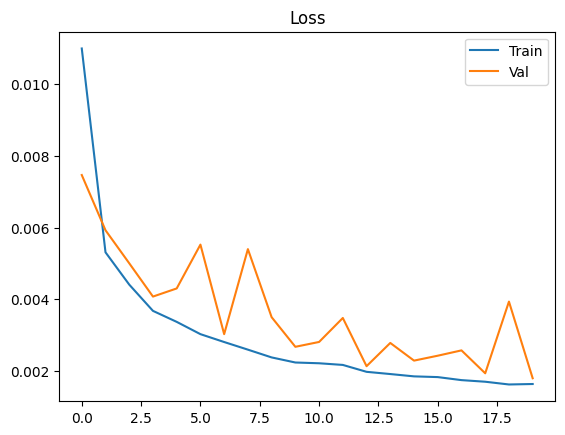

In [7]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

model = Model()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_fn = nn.MSELoss()

combined_history = train(model, X_train, y_train, X_val, y_val,epochs=20)

plt.plot(combined_history[:,0], label="Train")
plt.plot(combined_history[:,1], label="Val")
plt.title('Loss')
plt.legend()
plt.show()

### Evaluate Model

Train Loss:	 0.0016383370185698628
Val Loss:	 0.0017989407714485424
Test Loss:	 0.0022268282434401046

Test MAE:	 0.017480844193057128
Test RMSE:	 0.04609225553983593


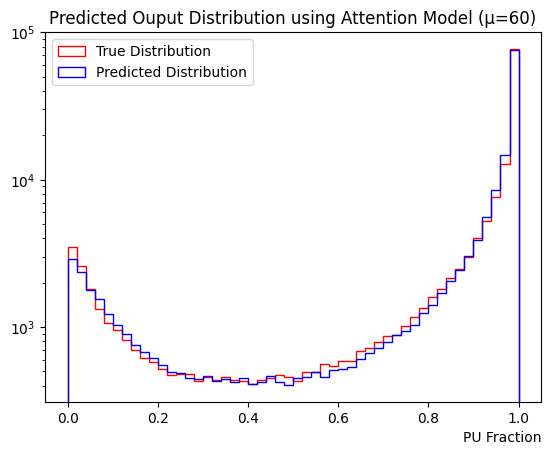

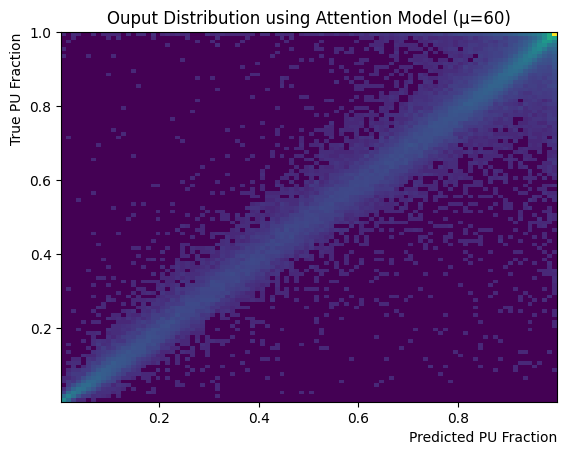

In [8]:
model.eval()
cumulative_loss_test = 0
cumulative_MSE_test = 0
cumulative_BCE_test = 0
predicted_labels = []
true_labels = []
binary_pred = []
binary_true = []

num_test = len(X_test)
for i in range(num_test):
    output, jet_weights, trk_weights, cross_weights = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))
    
    loss=loss_fn(output, y_test[i].to(device))
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
        
    for j in range(output.shape[0]): 
        predicted_labels.append(float(output[j][0].detach().cpu().numpy()))
        true_labels.append(float(y_test[i][j][0].detach().numpy()))
    
cumulative_loss_test = cumulative_loss_test / num_test
    
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)
print()
print("Test MAE:\t", mean_absolute_error(true_labels, predicted_labels))
print("Test RMSE:\t", root_mean_squared_error(true_labels, predicted_labels))

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()

plt.title("Ouput Distribution using Attention Model (\u03BC=60)")
plt.hist2d(predicted_labels,true_labels, bins=100,norm=mcolors.PowerNorm(0.2))
plt.xlabel('Predicted PU Fraction',loc='right')
plt.ylabel('True PU Fraction',loc='top')
plt.show()

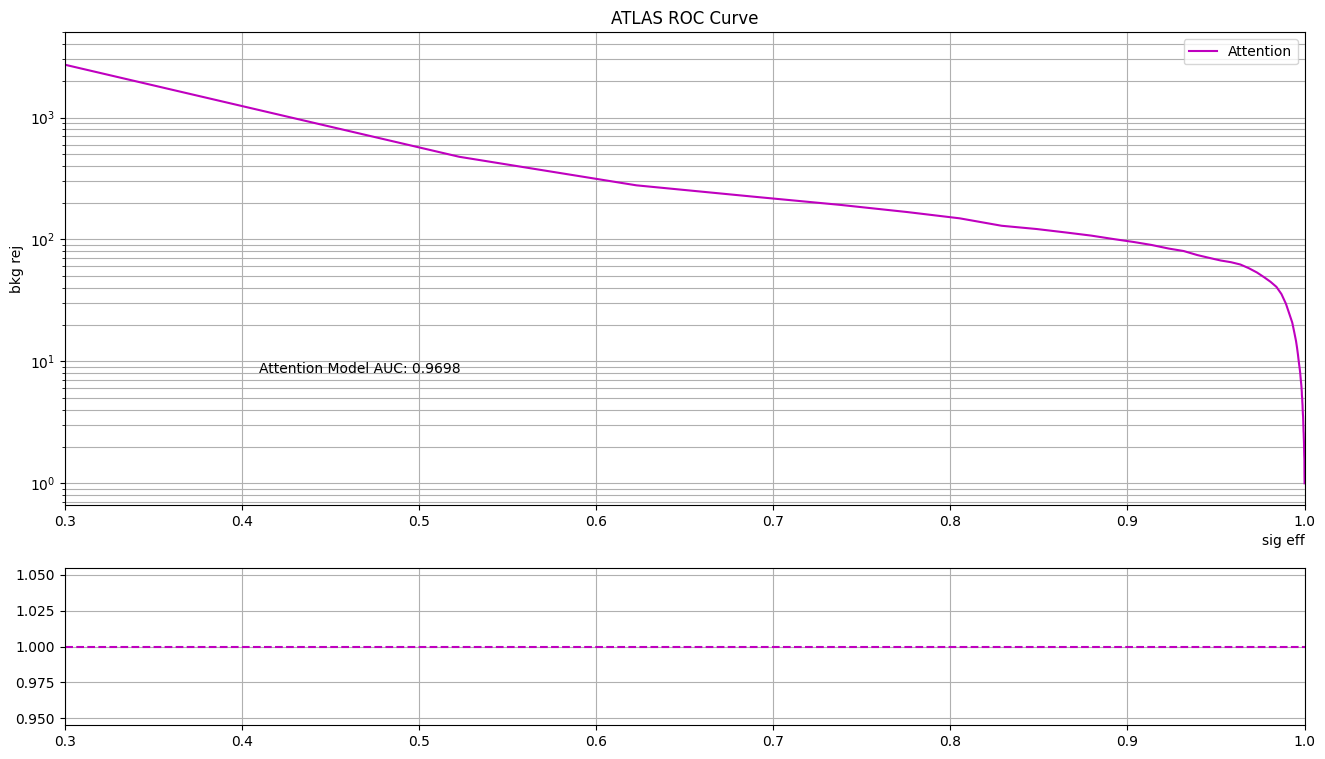

JVT	 Binary Accuracy:  0.9852399262997676 	F1 Score:  0.9910459366533428



In [18]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.999,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(((y_pred[bkg] > threshold).sum()  / y_true[bkg].shape[0]))
        
    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

def get_metrics(y_true, y_pred, threshold):
    y_Pred = np.array(y_pred > threshold).astype(int)
    y_True = np.array(y_true > threshold).astype(int)
    x,y, thresholds = ATLAS_roc(y_True, y_pred)
    AUC = roc_auc_score(y_True, y_Pred)
    BA = accuracy_score(y_True, y_Pred)
    f1 = f1_score(y_True, y_Pred)
    return x,y,thresholds,AUC,BA,f1


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})

x1,y1,th1,AUC1,BA1,f11 = get_metrics(np.array(true_labels), np.array(predicted_labels), 0.7)

ax1.set_title("ATLAS ROC Curve")
ax1.set_xlabel("sig eff",loc='right')
ax1.set_ylabel("bkg rej")

ax1.plot(x1,y1, label="Attention",color='m')
AUC1 = "Attention Model AUC: " + str(round(AUC1,4))
ax1.text(0.41,8,AUC1)

x = 1-np.flip(th1)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x1),np.flip(y1))
ax2.plot(x,ratio1,linestyle='--',color='m')

# General Plot Settings
ax1.legend()
ax1.set_yscale('log')
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_xlim(0.3,1)
ax2.set_xlim(0.3,1)
plt.show()

print("JVT\t","Binary Accuracy: ", BA1, "\tF1 Score: ", f11)
print("")

In [12]:
#print(model)
np.sum(p.numel() for p in model.parameters() if p.requires_grad)

/tmp/ipykernel_2253530/3063903079.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(p.numel() for p in model.parameters() if p.requires_grad)


4108545

In [13]:
torch.save(model,"PUFNN.torch")

### Visualize Attention Scores

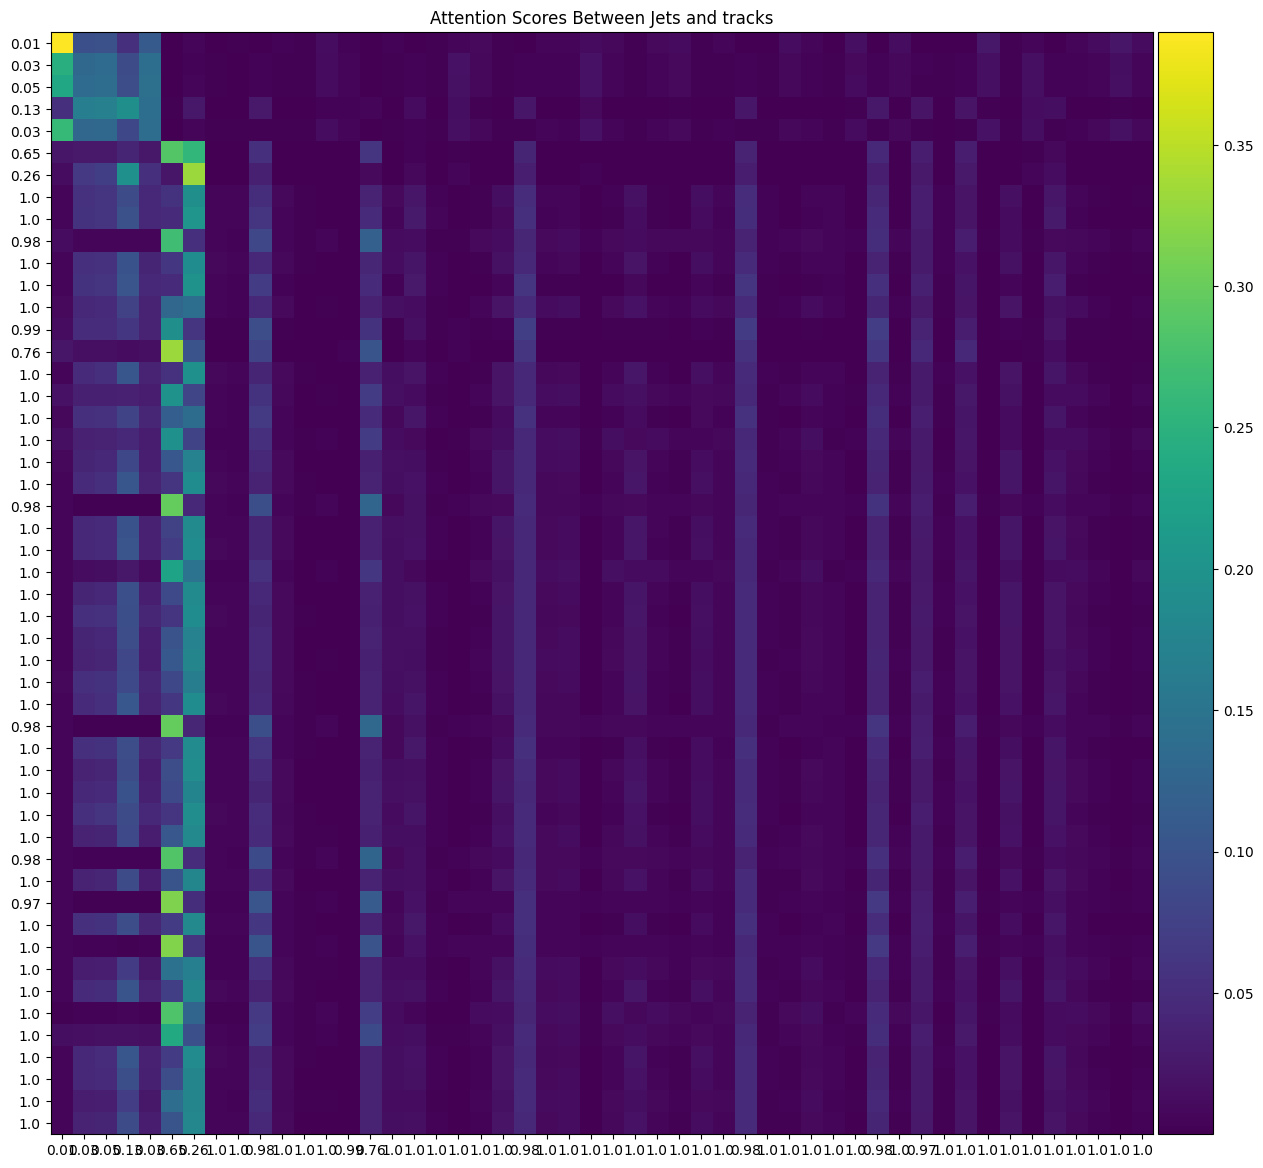

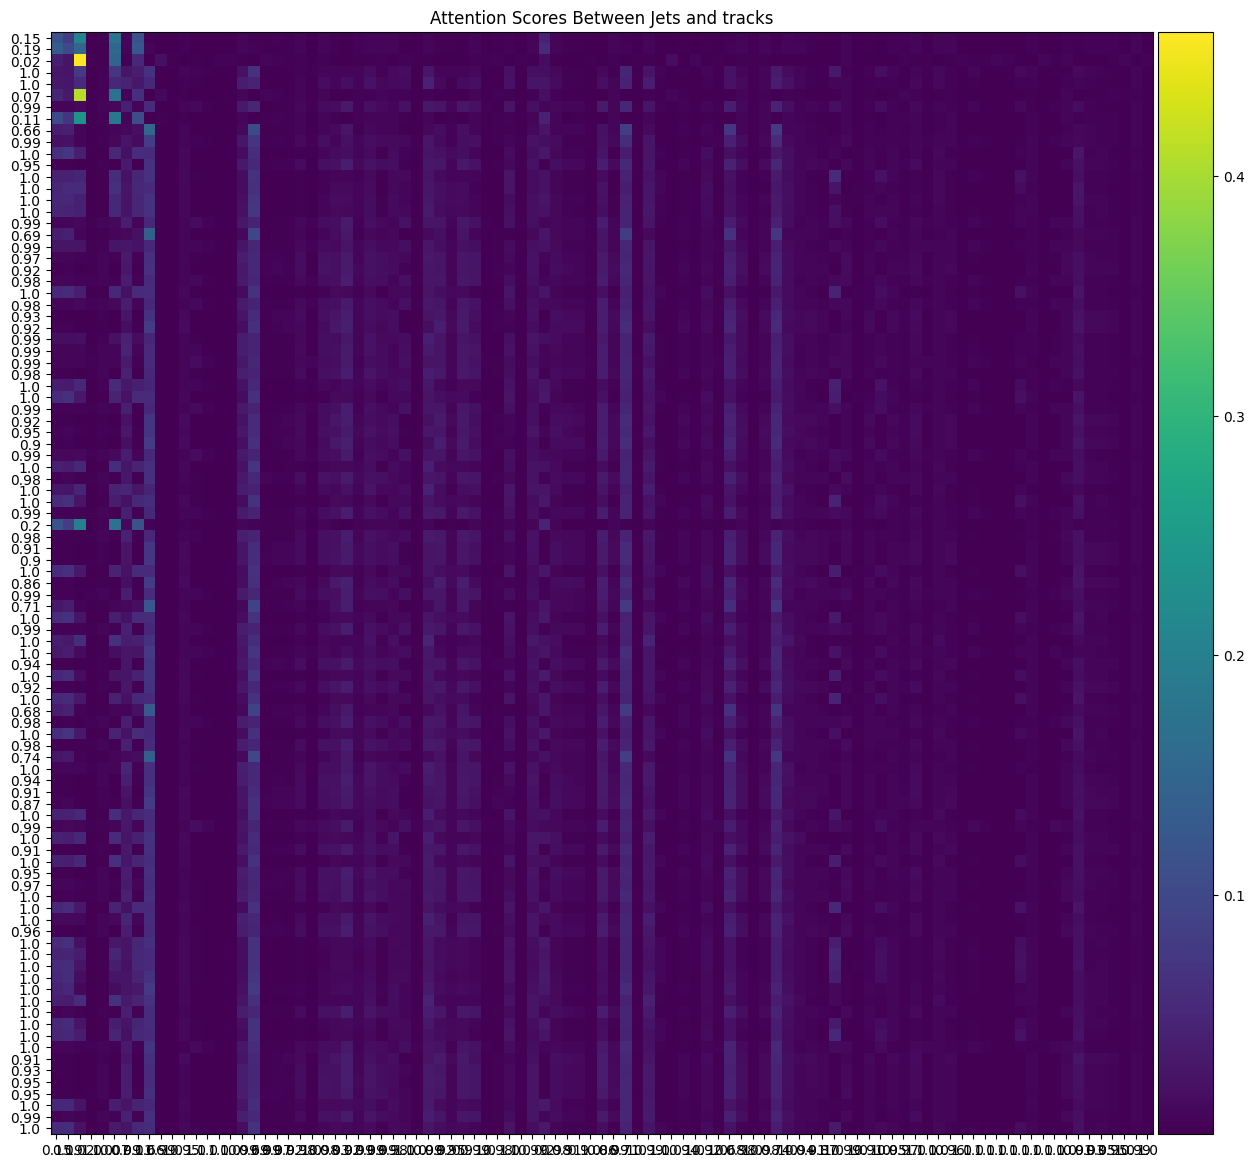

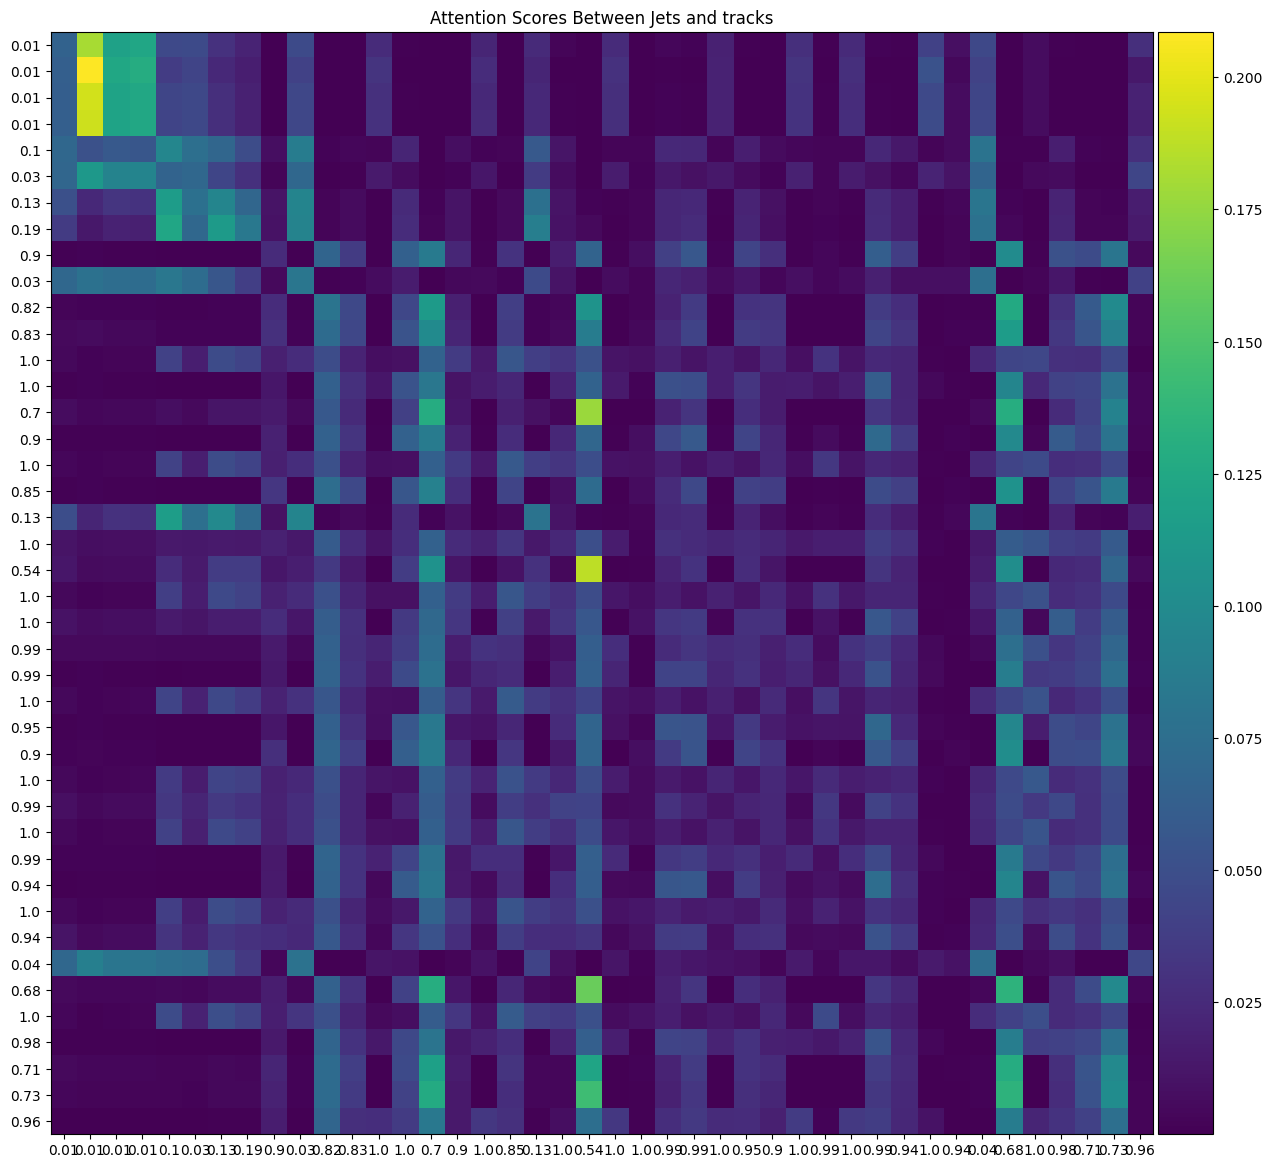

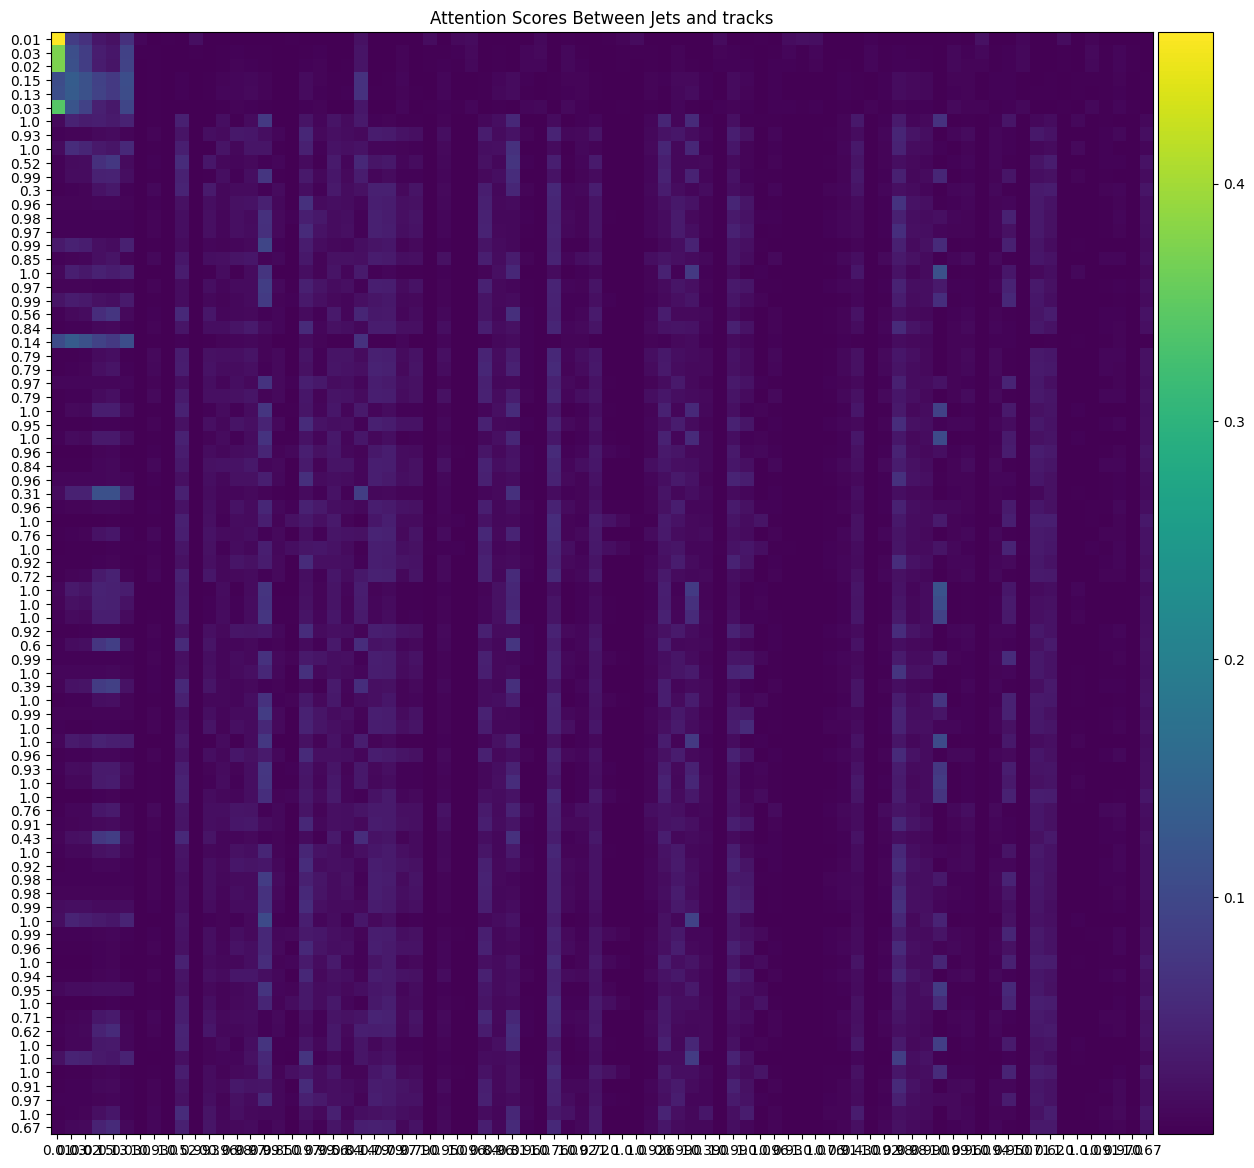

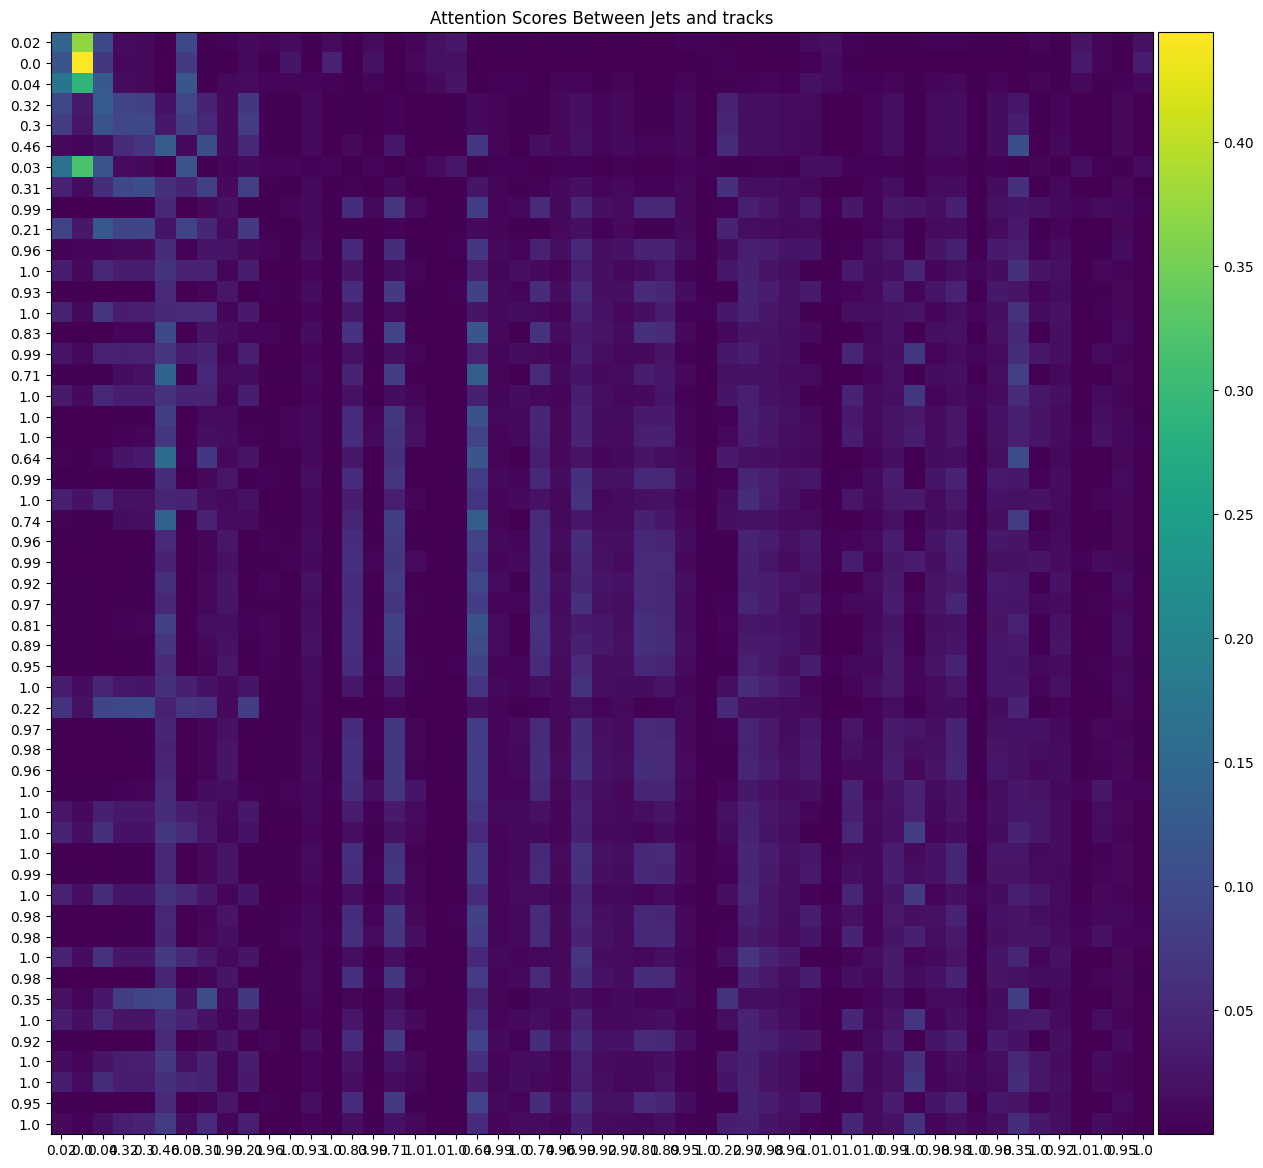

In [14]:
plot_events=5
for i in range(plot_events):
    # Get Model Predictions
    model.eval()
    output, jet_weights, trk_weights, cross_weights = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))
    
    num_jets = len(output)
    
    ticks = [x for x in range(num_jets)]
    jet_labels= [round(float(label.detach().cpu().numpy()[0]),2) for label in y_test[i]]   

    fig, (ax1) = plt.subplots(1, 1, figsize=(15,15))
    im0 = ax1.imshow(jet_weights.detach().cpu().numpy())
    ax1.set_xticks(ticks, jet_labels)
    ax1.set_yticks(ticks, jet_labels)
    ax1.set_title("Attention Scores Between Jets and tracks")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')